# Genotype qc
- This is a script for QC of genotype data
- Also, this shows how we conducted PCA

## Example of genotype data 

In [1]:
HLAGENE="HLA_DRB1"
IFILE <- paste0("../../data/genotype/", HLAGENE, ".matrix")
d1 <- read.table(IFILE, header=T, row.names=1, stringsAsFactors = F)
head(d1,n=10)[,1:5]

,HLA_DRB1_01_01,HLA_DRB1_01_02,HLA_DRB1_01_03,HLA_DRB1_03_01,HLA_DRB1_04_01
HIP00110,0,0,0,0,0
HIP00169,0,0,0,0,0
HIP00594,0,0,0,0,0
HIP00602,0,0,0,0,0
HIP00614,0,0,1,0,0
HIP00640,0,0,0,0,1
HIP00707,1,0,0,0,0
HIP00710,0,0,0,0,0
HIP00715,0,0,0,0,0
HIP00728,0,0,0,0,0


In [2]:
#sum of rows = 2, because each individual has two alleles of DRB1
table(rowSums(d1))


  2 
630 

## Sample call rate
- row call rate samples will be revmoved

In [3]:
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1")){
    
    IFILE <- paste0("../../data/genotype/", HLAGENE, ".matrix")
    OFILE <- paste0("../../data/genotype/", HLAGENE, ".lowcallrate.samples")
    
    d1 <- read.table(IFILE, header=T, row.names=1, stringsAsFactors = F)
    sum <- rowSums(d1)
    remove_samples <- names( sum[sum==0] ) #samples which are no called genotype
    
    #write.table(remove_samples, OFILE, col.names=F, row.names=F, append=F, quote=F, sep="\t")
}

## Allele frequency
- low MAF alleles will be removed

In [4]:
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1")){
    OFILE <- paste0("../../data/genotype/", HLAGENE, ".4digit.freq")
    aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".matrix"), 
                        header=T, row.names=1, stringsAsFactors = F)
    freq <- colSums(aamat) / (2 * nrow(aamat))
    dump <- data.frame(id=names(freq), freq)
    #write.table(dump, OFILE, col.names=T, row.names=F, append=F, quote=F, sep="\t")
}

## Low allele frequency amino acid variants
- low MAF alleles will be removed

In [5]:
#low frequent (<1%)
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1")){
    
    OFILE <- paste0("../../data/genotype/", HLAGENE, ".lowfreq.4digit.genotypes")
    d1 <- read.table(paste0("../../data/genotype/", HLAGENE, ".4digit.freq"), header=T, stringsAsFactors = F)
    remove_genotypes <- subset(d1, freq < 0.01 | freq > 0.99)$id
    #write.table(remove_genotypes, OFILE, col.names=F, row.names=F, append=F, quote=F, sep="\t")
}

## HWE

In [6]:
options(warn=-1)

for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1")){
    
    aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".matrix"), header=T, row.names=1, stringsAsFactors = F)
    if( file.info(paste0("../../data/genotype/", HLAGENE, ".lowfreq.4digit.genotypes"))$size >0 ){
        lowfreq <- read.table(paste0("../../data/genotype/", HLAGENE, ".lowfreq.4digit.genotypes"), header=F, stringsAsFactors = F)[,1]
    }else{
        lowfreq <- c()
    }
    pass <- setdiff(colnames(aamat), lowfreq)
    aamat2 <- aamat[,pass]
    
    OFILE <- paste0("../../data/genotype/", HLAGENE, ".hwe_lowp.4digit.genotypes")
    
    hwe_p <- apply(aamat2, 2, function(x){
        x <- as.numeric(x)
        #observed data
        a0 <- length(x[x==0])
        a1 <- length(x[x==1])
        a2 <- length(x[x==2])
         
        freq <- sum(x) / (2*length(x))
         
        #expedted data
        P_a0 <- ( 1 - freq )^2 
        P_a1 <- 2 * ( 1 - freq )*freq
        P_a2 <- freq^2
             
        chitest <- chisq.test(c(a0, a1, a2), p = c(P_a0, P_a1, P_a2)) #simulate.p.value = TRUE, B = 2000
        chitest$p.value
    })
    
    remove_genotypes <- names(hwe_p[hwe_p<=1e-04])
    #write.table(remove_genotypes, OFILE, col.names=F, row.names=F, append=F, quote=F, sep="\t")
}

## Compare allele frequency with reference data
- The discortance could be due to ethnic background differences
- T1DGC: EUR, Robin: mixed

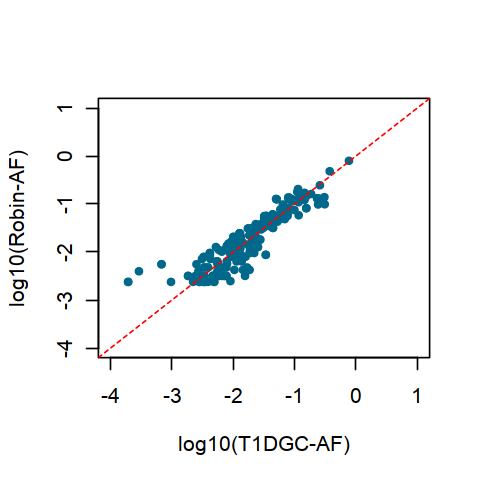

In [7]:
#T1DGC reference data
ref <- read.table("../../data/genotype/T1DGC.FRQ.frq", header=T, stringsAsFactors = F)
ref <- ref[,c("SNP","MAF")]
ref$SNP <- gsub("-", "\\.", ref$SNP)

#robin data (use all samples)
robin <- data.frame()
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1", "HLA_DRB1")){
    
    d1 <- read.table(paste0("../../data/genotype/", HLAGENE, ".4digit.freq"),header=T,stringsAsFactors = F)
    
    #if( file.info(paste0("genotype_qc/", HLAGENE, ".lowfreq.4digit.genotypes"))$size >0 ){
    #    lowfreq <- read.table(paste0("genotype_qc/", HLAGENE, ".lowfreq.4digit.genotypes"), header=F, stringsAsFactors = F)[,1]
    #}else{
        lowfreq <- c()
    #}
    
    #if( file.info(paste0("genotype_qc/", HLAGENE, ".hwe_lowp.4digit.genotypes"))$size >0 ){
    #    hwe <- read.table(paste0("genotype_qc/", HLAGENE, ".hwe_lowp.4digit.genotypes"), header=F, stringsAsFactors = F)[,1]
    #}else{
        hwe <- c()
    #}
    
    pass <- setdiff(d1$id, lowfreq)
    pass <- setdiff(pass, hwe)
    
    d1 <- d1[is.element(d1$id, pass), ]
    
    robin <- rbind(robin, d1)
}

robin$id <- sapply(strsplit(as.character(robin$id),"_"),
                   function(x){paste0(x[1],"_",x[2],"_",x[3],x[4])})

#merge
M <- merge(ref, robin, by.x="SNP", by.y="id")

options(repr.plot.width=4, repr.plot.height=4)
plot(log10(M$MAF), log10(M$freq), 
     xlab="log10(T1DGC-AF)", ylab="log10(Robin-AF)",
     xlim=c(-4,1),ylim=c(-4,1),
     pch=20, col="deepskyblue4")
abline(a=0, b=1, col="red", lty=2)


## Post qc amino acid genotype matrix

In [8]:
#maf 1%
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C", "HLA_DPA1",
   "HLA_DPB1", "HLA_DQA1", "HLA_DQB1", "HLA_DRB1")){
    
    OFILE <- paste0("../../data/genotype/", HLAGENE, ".4digit.postqc.matrix")
    
    #genotype
    aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".matrix"), 
                        header=T, row.names=1, stringsAsFactors = F)
    
    #remove low freq. hwe low p markers
    if( file.info(paste0("../../data/genotype/", HLAGENE, ".lowfreq.4digit.genotypes"))$size >0 ){
        lowfreq <- read.table(paste0("../../data/genotype/", HLAGENE, ".lowfreq.4digit.genotypes"), 
                              header=F, stringsAsFactors = F)[,1]
    }else{
        lowfreq <- c()
    }
    
    if( file.info(paste0("../../data/genotype/", HLAGENE, ".hwe_lowp.4digit.genotypes"))$size >0 ){
        hwe <- read.table(paste0("../../data/genotype/", HLAGENE, ".hwe_lowp.4digit.genotypes"), 
                          header=F, stringsAsFactors = F)[,1]
            #there was minor error here. failed to remove hwe low p snps
    }else{
        hwe <- c()
    }
    
    pass <- setdiff(colnames(aamat), lowfreq)
    pass <- setdiff(pass, hwe)
    
    aamat <- aamat[, is.element(colnames(aamat), pass)]
    
    dump <- data.frame(id=row.names(aamat), aamat)
    #write.table(dump, OFILE, col.names=T, row.names=F, append=F, quote=F, sep="\t")
}


## PCA in all genotypes

In [9]:
OFILE <- paste0("../../data/genotype/HLA_A_B_C_DQB1_DRB1_4digit.pca")

#use HLA-A,B,C, DQB1 and DRB1 because they are genotypes 630 or 631 samples
all_samples <- c()
for( HLAGENE in c("HLA_A", "HLA_B", "HLA_C","HLA_DQB1", "HLA_DRB1")){
    #post qc amino acid genotype
    aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".4digit.postqc.matrix"), 
                        header=T, row.names=1, stringsAsFactors = F)
    all_samples <- c(all_samples, row.names(aamat))
}
count <- table(all_samples)

common_samples <- names(count[count==5])
length(common_samples) #samples used for this analysis

#merge all data
HLAGENE="HLA_A"
aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".4digit.postqc.matrix"), 
                    header=T, row.names=1, stringsAsFactors = F)
aamat <- aamat[common_samples, ]
allmat <- aamat
ncol(allmat)

for( HLAGENE in c("HLA_B", "HLA_C","HLA_DQB1", "HLA_DRB1")){
    #post qc amino acid genotype
    aamat <- read.table( paste0("../../data/genotype/", HLAGENE, ".4digit.postqc.matrix"), 
                        header=T, row.names=1, stringsAsFactors = F)
    aamat <- aamat[common_samples, ]
    allmat <- cbind(allmat, aamat)
    show(ncol(allmat))
}
ncol(allmat)

aamat <- allmat

#LD pruning (rsq > 0.5)
cov <- cor(aamat)

remove <- c()
for( i in 1:ncol(aamat) ){    
    if( is.element(i, remove) ){ next } else {
        rsq <- cov[,i]^2
        ldmarker <- ( 1:ncol(aamat) )[ rsq > 0.5 ]
        ldmarker <- setdiff(ldmarker, i) #keep self
        remove <- c(remove, ldmarker)
    }
}
remove <- unique(remove)
keep <- setdiff(1:ncol(aamat), remove)

aamat <- aamat[, keep]
dim(aamat)
    
#PCA
pca <- prcomp(aamat, scale = TRUE)

#pca plot
out <- pca$x
dump <- data.frame(id=row.names(out), out)
write.table(dump, OFILE, col.names=T, row.names=F, append=F, quote=F, sep="\t")

[1] 628

[1] 16

[1] 35
[1] 51
[1] 64
[1] 84


[1] 84

[1] 628  71

In [10]:
#summary of pca
summary(pca)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     1.6935 1.62378 1.59242 1.58174 1.50130 1.47246 1.43707
Proportion of Variance 0.0404 0.03714 0.03572 0.03524 0.03174 0.03054 0.02909
Cumulative Proportion  0.0404 0.07753 0.11325 0.14848 0.18023 0.21077 0.23985
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.41044 1.39552 1.35725 1.32006 1.28739 1.25814 1.24218
Proportion of Variance 0.02802 0.02743 0.02595 0.02454 0.02334 0.02229 0.02173
Cumulative Proportion  0.26787 0.29530 0.32125 0.34579 0.36913 0.39143 0.41316
                         PC15    PC16    PC17   PC18    PC19    PC20    PC21
Standard deviation     1.2241 1.20403 1.18609 1.1825 1.16522 1.15183 1.13073
Proportion of Variance 0.0211 0.02042 0.01981 0.0197 0.01912 0.01869 0.01801
Cumulative Proportion  0.4343 0.45468 0.47450 0.4942 0.51331 0.53200 0.55001
                          PC22    PC23